Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

In [334]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Data preparation

In [250]:
try:
    df = pd.read_csv('/datasets/car_data.csv')
except:
    df = pd.read_csv('datasets/car_data.csv')
total_observations = len(df)

### **data processing: general**

In [251]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47
8,04/04/2016 23:42,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,04/04/2016 00:00,0,94505,04/04/2016 23:42
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,0,27472,31/03/2016 17:17


In [252]:
# rename columns
df.columns = ['date', 'price', 'vehicle_type', 'reg_year', 'gearbox',
             'power', 'model', 'mileage', 'reg_month', 'fuel_type',
              'brand','not_repaired', 'date_profile_created', 'num_pictures', 'postal_code',
             'last_seen']

In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
date                    354369 non-null object
price                   354369 non-null int64
vehicle_type            316879 non-null object
reg_year                354369 non-null int64
gearbox                 334536 non-null object
power                   354369 non-null int64
model                   334664 non-null object
mileage                 354369 non-null int64
reg_month               354369 non-null int64
fuel_type               321474 non-null object
brand                   354369 non-null object
not_repaired            283215 non-null object
date_profile_created    354369 non-null object
num_pictures            354369 non-null int64
postal_code             354369 non-null int64
last_seen               354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


   **Note...** <br>
1. *date*, *date_profile_created* and *last_seen* are not Date type <br>
2. There are N/A-values in 5 columns: *vehicle_type*, *gearbox*, *model*, *fuel_type*, *not_repaired*

In [254]:
# change type of date
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
df['date_profile_created'] = pd.to_datetime(df['date_profile_created'], format='%d/%m/%Y %H:%M')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%d/%m/%Y %H:%M')

In [255]:
df[['date','date_profile_created','last_seen']]

,date,date_profile_created,last_seen
0,2016-03-24 11:52:00,2016-03-24,2016-04-07 03:16:00
1,2016-03-24 10:58:00,2016-03-24,2016-04-07 01:46:00
2,2016-03-14 12:52:00,2016-03-14,2016-04-05 12:47:00
3,2016-03-17 16:54:00,2016-03-17,2016-03-17 17:40:00
4,2016-03-31 17:25:00,2016-03-31,2016-04-06 10:17:00
...,...,...,...
354364,2016-03-21 09:50:00,2016-03-21,2016-03-21 10:42:00
354365,2016-03-14 17:48:00,2016-03-14,2016-04-06 00:46:00
354366,2016-03-05 19:56:00,2016-03-05,2016-03-11 18:17:00
354367,2016-03-19 18:57:00,2016-03-19,2016-04-07 07:15:00


In [256]:
# compare *date* and *date_profile_created*
print('Comparison *date* and *date_profile_created*:')
print('Rows where dates are differ:',df[df['date'].dt.date != df['date_profile_created'].dt.date].shape[0])
print('% from total rows: {:.1%}'.format(
                    df[df['date'].dt.date != df['date_profile_created'].dt.date].shape[0] / len(df)) )


Comparison *date* and *date_profile_created*:
Rows where dates are differ: 11784
% from total rows: 3.3%


   **Note...** <br>
There is so little differences between *date* and *date_profile_created*. <br>
DateCrawled — date profile was downloaded from the database <br>
DateCreated — date of profile creation <br>
How does it could influence on price? What the connection? <br>
(assumption) Maybe in summer months sales are higher than in winter? And if the profile created in summer, it could mean that the price is higher/lower... okay... We will not drop this feature. <br>
But we drop *date* (DateCrawled) because it mostly duplicate *date_profile_created* and has no any reason to stay it. For what? Somebody downloaded it in DateCrawled, how it can influence on the price of car. <br>

In [257]:
df = df.drop(['date'], axis=1)

In [258]:
df.describe()

,price,reg_year,power,mileage,reg_month,num_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


   **Note...** <br>
1. *num_pictures* has no information. All values are zeros. So we can drop it. <br>
2. There are 0-values in *price*, *power* and *reg_month*. We can interprete it as N/A. <br>

In [259]:
df = df.drop(['num_pictures'], axis=1)

### **data processing: zeros and N/A-values**

In [260]:
df.head()

,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel_type,brand,not_repaired,date_profile_created,postal_code,last_seen
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:00
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:00
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:00
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:00
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:00


   **Note...** <br>
Many of columns are cathegorical parameters.

#### price

In [261]:
# zeros in *price*
print('zeros in *price* {:.1%}'.format(df[df['price'] == 0].shape[0] / total_observations))

zeros in *price* 3.0%


   **Note...** <br>
1. We can't train the model to predict or verificate *price* if there are zeros values. <br>
2. We can painless drop these values. There are only 3% of all dataset. <br>

In real we should check if it is possible, that the price is zero. Maybe for some kind of vehicle it better give it somebody for free, rather than pay taxes.

In [262]:
# drop zeros in *price*
df = df[df['price'] != 0]

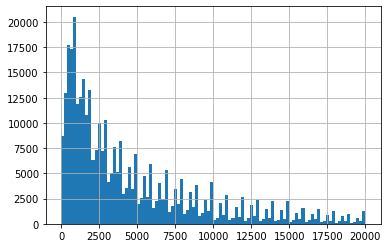

In [263]:
df['price'].hist(bins=100)

   **Note...** <br>
1. There are a lot of local 'extremums', it looks like a saw. Maybe it is because the cars with 999 have better chance to be saled, than with prce 1000.  <br>

In [264]:
df.query('price < 100').shape[0]

2542

   **Note...** <br>
1. We find out that there are a lot of (2500+) cars with price less than 100 EUR. There are even some of them with price 1EUR.<br>
2. So.. maybe we shouldn't drop zero-price values (as we did). Maybe it s possible.

#### vehicle_type

In [265]:
# check vehicle_type
df['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [266]:
print('N/A-values in *vehicle_type* {:.1%}'.format(
                                df[df['vehicle_type'].isnull()].shape[0] / total_observations ))

N/A-values in *vehicle_type* 9.5%


In [267]:
# compare prices in N/A-values and different cathegories (below: groupby)
print('Median price of N/A-values in *vehicle_type* {:.0f}'.format(
                                df[df['vehicle_type'].isnull()]['price'].median() ))

Median price of N/A-values in *vehicle_type* 1400


In [268]:
df.groupby('vehicle_type').agg({'price': ['count', 'median']})

price       
              count median
vehicle_type              
bus           28345   4300
convertible   19865   5500
coupe         15636   4100
other          3086   2450
sedan         89405   3000
small         78018   1599
suv           11791   8590
wagon         63701   3300

   **Note...** <br>
1. Without any doubts prices in N/A-values in *vehicle_type* are totaly differ from the others. And it lower! the closest cathegory is small. <br>
2. We should check, why the prices in this cathegory are so low. <br>
3. We have tried to find (part of code has been deleted) any connection this cathegory N/A-values in vain.
4. We will fillna *vehicle_type* with new cathegory 'unknown'.

In [269]:
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')

#### reg_year

In [270]:
x = df['reg_year'].unique()
x.sort()
print(x)

[1000 1001 1039 1111 1234 1255 1300 1400 1500 1600 1602 1800 1910 1923
 1925 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1940
 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954
 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968
 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982
 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019 2066 2200 2222 2290 2500
 2800 2900 3000 3200 3700 3800 4000 4100 4500 4800 5000 5300 5555 5600
 5900 5911 6000 6500 7000 7100 7800 8000 8200 8500 8888 9000 9450 9999]


In [271]:
df.groupby('reg_year').agg({'price' : ['count']})

,price
,count
reg_year,
1000,31
1001,1
1039,1
1111,1
1234,4
...,...
8500,1
8888,1


   **Note...** <br>
1. There are a lot of cars from future and great past. Nice.
2. It seems that this typos 1001 could be 2001, 1039 be 1939 and so on... let's use apply to *reg_year*
3. Count of this typos is too little.

In [272]:
def reg_year_update(x):
    if x < 1099:
        return x % 100 + 2000
    elif x < 1900:
        return x // 100 + 2000
    elif x == 1910:
        return x % 100 + 2000
    elif x >= 2030:
        return x // 100 + 1900
    else:
        return x

In [273]:
df['reg_year'] = df['reg_year'].apply(reg_year_update)

In [274]:
x = df['reg_year'].unique()
x.sort()
print(x)

[1920 1922 1923 1925 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936
 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951
 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965
 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979
 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2039]


In [275]:
df.groupby('reg_year').agg({'price' : ['count']})

,price
,count
reg_year,
1920,1
1922,3
1923,2
1925,4
1927,1
...,...
2016,8971
2017,9895


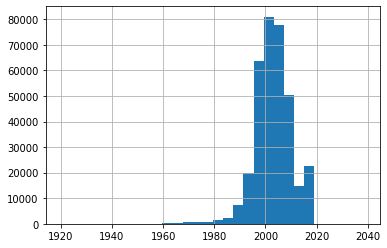

In [276]:
df['reg_year'].hist(bins=30)

######   **Note...** <br>
1. Count of sells of cars <= 1970 is too little. We can sum up them to make a group with comparable number of cars.

In [277]:
def reg_year_update2(x):
    if x < 1971:
        return 1970
    else:
        return x
    
df['reg_year'] = df['reg_year'].apply(reg_year_update2)

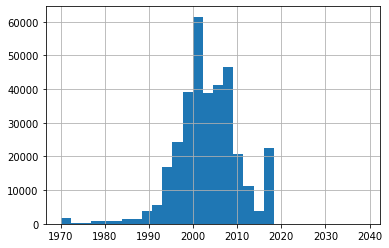

In [278]:
df['reg_year'].hist(bins=30)

#### gearbox

In [279]:
print('N/A-values in *gearbox* {:.1%}'.format(
                                df['gearbox'].isnull().sum() / len(df) ))

df['gearbox'].unique()

N/A-values in *gearbox* 5.1%


array(['manual', 'auto', nan], dtype=object)

######   **Note...** <br>
1. It is not a big problem to set N/A-values to a new cathegory.
2. There are no many N/A-values, so we can drop it.
3. I mean there are no good reasons to do this or that, so we decided to remain N/A-values as new cathegory

In [280]:
df['gearbox'] = df['gearbox'].fillna('unknown')

In [281]:
print('N/A-values in updated *gearbox* {:.1%}'.format(
                                df['gearbox'].isnull().sum() / len(df) ))

N/A-values in updated *gearbox* 0.0%


#### power

######   **Note...** <br>
1. There are values with *power* > 500 ! What a rocket! <br>
For example (from google) <br>
-- cayenne porsche 2013: 300-horsepower <br>
-- opel astra hp 1999: 78 hp <br>
-- 2003 Mercedes-Benz E 55 AMG : 476 hp (reason to use limit 500)

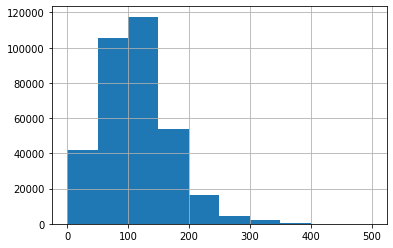

In [282]:
df['power'].hist(range=[0,500])

In [283]:
print('Count of *power* > 500: {:.0f}'.format(
                                df[df['power'] > 500].shape[0] ))

Count of *power* > 500: 429


In [284]:
df[df['power'] > 500].head(30)

,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel_type,brand,not_repaired,date_profile_created,postal_code,last_seen
1816,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22,22043,2016-03-22 21:43:00
4060,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03,60326,2016-04-07 14:56:00
5328,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,NaN,2016-03-29,33154,2016-04-06 05:44:00
6296,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,2016-03-31,44379,2016-04-01 03:41:00
6504,3000,small,2009,manual,771,punto,125000,0,petrol,fiat,NaN,2016-03-14,40721,2016-03-14 15:54:00
6637,600,small,1996,manual,603,corsa,150000,8,petrol,opel,yes,2016-03-31,70327,2016-04-06 14:17:00
7661,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,NaN,2016-04-02,65830,2016-04-06 11:46:00
7720,1500,small,2000,manual,1400,NaN,150000,0,petrol,honda,NaN,2016-04-02,21509,2016-04-04 09:15:00
8057,500,small,2002,manual,620,ypsilon,150000,12,petrol,lancia,NaN,2016-03-15,55566,2016-04-06 03:15:00
9664,2599,unknown,2016,manual,1779,zafira,150000,0,petrol,opel,no,2016-03-14,60326,2016-04-07 09:45:00


######   **Note...** <br>
1. Without any doubts it is mistake. Even we haven't found jaguar with 600 hs. <br>
2. What to do? We can't just randomly set values. <br>
3. The best thing is to find the similar model + brand and set the similar value. We have done it below. <br>
4. I could drop this values, because there are only 429 from the whole dataset. But it is better to remain them.

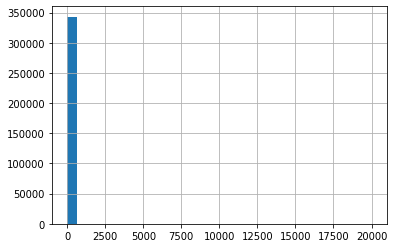

In [285]:
df['power'].hist(bins=30)

**So...** The same problem with values close to zero.

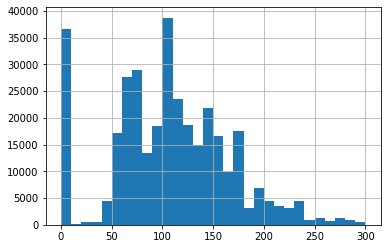

In [286]:
df['power'].hist(bins=30,range=[0,300])

In [287]:
print('0-values in *power* {:.1%}'.format(
                                df[df['power'] == 0].shape[0] / len(df) ))

0-values in *power* 10.6%


**So...** We can't just drop it. 10% of data is a huge volume.

In [288]:
group_model_median_power = df[df['power'] > 0].groupby('model').agg({'power' : ['median']})
group_model_median_power = group_model_median_power.reset_index(drop=False)
group_model_median_power.columns = ['model','median_power']
group_model_median_power

,model,median_power
0,100,133.0
1,145,103.0
2,147,120.0
3,156,150.0
4,159,170.0
...,...,...
244,yaris,75.0
245,yeti,110.0
246,ypsilon,60.0
247,z_reihe,170.0


In [289]:
df = df.reset_index(drop=True)

In [290]:
def find_power(table, model_x):
    try:
        return int(table[ table['model'] == model_x]['median_power'].values[0])
    except:
        return 0

**ATTENTION!** Below cell runs for 2-3 minutes!

In [291]:
for k in range(len(df)):
    if df.loc[k, 'power'] == 0:
        df.loc[k, 'power'] = find_power(group_model_median_power, df.loc[k, 'model'])

In [292]:
# check if we miss something
df[df['power'] == 0]['model'].unique()

array([nan, 'serie_1'], dtype=object)

**So...** We still have N/A-values in updated *power*. <br>
The reason is that there are N/A-values in *model* <br>
Moreover we have 'serie_1' model. Let's take a look.

In [293]:
df[df['model'] == 'serie_1']

,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel_type,brand,not_repaired,date_profile_created,postal_code,last_seen
227092,3800,wagon,1978,manual,0,serie_1,30000,0,gasoline,land_rover,NaN,2016-03-30,49824,2016-03-30 11:39:00


**So...** land_rover serie_1 is wthout data of power at all. We can add it without automatization. <br>
From https://en.wikipedia.org/wiki/Land_Rover_series we obtain 76hp


In [294]:
# write to database new data
for k_index in df[df['model'] == 'serie_1'].index:
    df.loc[k_index, 'power'] = 76

In [295]:
print('0-values in *power* {:.1%}'.format(
                                df[df['power'] == 0].shape[0] / len(df) ))

0-values in *power* 1.5%


**So...** We can drop N/A-values in updated *power*. <br>

In [296]:
df = df[df['power'] != 0]
df.reset_index(drop=True)

,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel_type,brand,not_repaired,date_profile_created,postal_code,last_seen
0,480,unknown,1993,manual,101,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:00
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:00
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:00
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:00
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338565,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016-03-19,96465,2016-03-19 20:44:00
338566,1150,bus,2000,manual,125,zafira,150000,3,petrol,opel,no,2016-03-27,26624,2016-03-29 10:17:00
338567,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,26135,2016-03-11 18:17:00
338568,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,87439,2016-04-07 07:15:00


#### model

In [297]:
print('N/A-values in *model* {:.1%}'.format(
                                df[df['model'].isnull()].shape[0] / len(df) ))


N/A-values in *model* 3.7%


**So...** The easiest way is to drop these values. <br>

In [298]:
df = df[df['model'].notnull()]

#### mileage

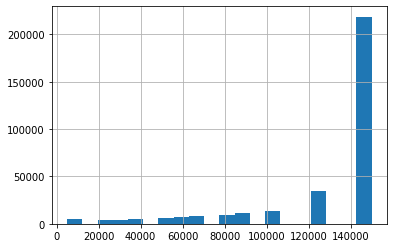

In [299]:
df['mileage'].hist(bins=20)

In [300]:
df[df['mileage'] > 140000]['mileage'].unique()

array([150000])

In [301]:
df[df['mileage'] < 1000]

,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel_type,brand,not_repaired,date_profile_created,postal_code,last_seen


   **Note...** <br>
1. It is strange, but the most popular value is 150000. It is just a number not range of numbers.
2. We haven't got too little values.
3. So, it is OK.

#### reg_month

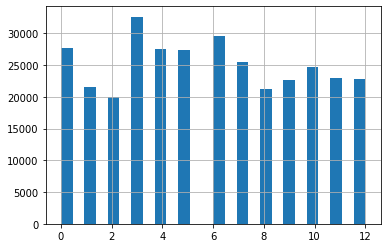

In [302]:
df['reg_month'].hist(bins=26)

In [303]:
print('Min value in *reg_month*:',df['reg_month'].min())
print('Max value in *reg_month*:',df['reg_month'].max())

Min value in *reg_month*: 0
Max value in *reg_month*: 12


   **Note...** <br>
1. There are only 12 months in a year, not 13. <br>
2. But we can close eyes, cause from mathematical point of view it is just another cathegory.

#### fuel_type

In [304]:
df['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [305]:
len(df[df['fuel_type'].isnull()])

23551

In [306]:
df = df.reset_index(drop=True)
df['fuel_type'] = df['fuel_type'].fillna('unknown')

   **Note...** <br>
1. There are a lot of N/A-values. We can't drop it <br>
2. Set a new cathegory.

#### brand

In [307]:
df['brand'].unique()

array(['volkswagen', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'opel', 'seat', 'citroen',
       'honda', 'fiat', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo',
       'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'porsche', 'rover', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

   **Note...** <br>
1. It is OK.

#### not_repaired

In [308]:
df['not_repaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

In [309]:
df['not_repaired'] = df['not_repaired'].fillna('unknown')

#### postal_code

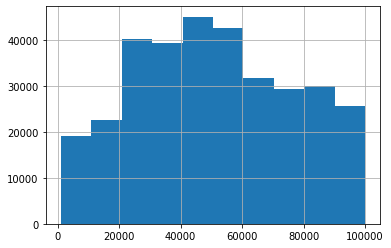

In [310]:
df['postal_code'].hist()

In [311]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326076 entries, 0 to 326075
Data columns (total 14 columns):
price                   326076 non-null int64
vehicle_type            326076 non-null object
reg_year                326076 non-null int64
gearbox                 326076 non-null object
power                   326076 non-null int64
model                   326076 non-null object
mileage                 326076 non-null int64
reg_month               326076 non-null int64
fuel_type               326076 non-null object
brand                   326076 non-null object
not_repaired            326076 non-null object
date_profile_created    326076 non-null datetime64[ns]
postal_code             326076 non-null int64
last_seen               326076 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(6), object(6)
memory usage: 34.8+ MB


In [312]:
len(df) / total_observations * 100

92.01594947639326

**RESULTs:** <br>
1. We have prepared data to develop the model. <br>
2. We have to drop ~8% of data. It is significant number, but it is still good. <br>
3. There are no N/A-values, mistakes, typos and error-0-values.

## Model training
Train different models with various hyperparameters <br> (You should make at least two different models, but more is better. Remember, various implementations of gradient boosting don't count as different models.) <br> The main point of this step is to compare gradient boosting methods with random forest, decision tree, and linear regression.

In [313]:
features = df.drop(['price','date_profile_created','last_seen'], axis=1)
target = df['price']

### linear regression
It is important, that there are cathegorical parameters. <br>
We use One-Hot Encoding (OHE) to convert them. <br>
Split in 30/70 proportion.

In [314]:
columns_cathegorical = ['vehicle_type', 'gearbox','model','fuel_type','brand','not_repaired']
features_OHE = pd.get_dummies(features, columns=columns_cathegorical, drop_first=True)

In [315]:
%%time
features_train, features_test, target_train, target_test = train_test_split(
                            features_OHE, target, test_size=0.3, random_state = 12345)

lr = LinearRegression()
lr.fit(features_train, target_train)
prediction_test = lr.predict(features_test)
prediction_train = lr.predict(features_train)

CPU times: user 22.5 s, sys: 9.79 s, total: 32.3 s
Wall time: 32.3 s


In [316]:
rmse_test_lr = mean_squared_error(target_test, prediction_test)
rmse_train_lr = mean_squared_error(target_train, prediction_train)
print('RMSE of linear regression model train: {:.1f}'.format(rmse_train_lr ** 0.5))
print('RMSE of linear regression model test: {:.1f}'.format(rmse_test_lr  ** 0.5))
# we used the RMSE metric to evaluate the models following the task.

RMSE of linear regression model train: 2728.1
RMSE of linear regression model test: 2763.2


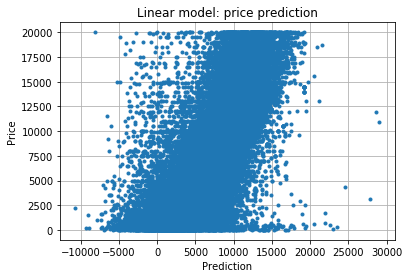

In [317]:
plt.figure()
plt.plot(prediction_test, target_test, '.')
plt.xlabel('Prediction')
plt.ylabel('Price')
plt.grid(True)
plt.title('Linear model: price prediction')
plt.show()

   **Note...** <br>
1. It is hard to undestand if the RMSE = 2763 is good or not (of course it looks too high). We see on plot that our prediction is too far from the ideal. <br>
2. We even have negative predicted prices. That is insane (but predictable for linear model)!

### Random forest

Let's take a look on two variants: <br>
1. n_estimators=20, max_depth=3,
2. n_estimators=50, max_depth=5.

In [318]:
%%time
rf = RandomForestRegressor(n_estimators=20,
                            max_depth=3,
                            random_state=12345)

rf.fit(features_train, target_train)
prediction_test = rf.predict(features_test)
prediction_train = rf.predict(features_train)

CPU times: user 23.4 s, sys: 472 ms, total: 23.9 s
Wall time: 24.5 s


In [319]:
rmse_test_rf = mean_squared_error(target_test, prediction_test)
rmse_train_rf = mean_squared_error(target_train, prediction_train)
print('RMSE of random forest model train: {:.1f}'.format(rmse_train_rf ** 0.5))
print('RMSE of random forest model test: {:.1f}'.format(rmse_test_rf ** 0.5))

RMSE of random forest model train: 2964.3
RMSE of random forest model test: 2972.0


This result worse than linear model (RMSE_linear = 2763). 

In [320]:
%%time
rf = RandomForestRegressor(n_estimators=50,
                            max_depth=5,
                            random_state=12345)

rf.fit(features_train, target_train)
prediction_test = rf.predict(features_test)
prediction_train = rf.predict(features_train)

CPU times: user 1min 43s, sys: 503 ms, total: 1min 43s
Wall time: 1min 46s


In [321]:
rmse_test_rf = mean_squared_error(target_test, prediction_test)
rmse_train_rf = mean_squared_error(target_train, prediction_train)
print('RMSE of random forest model train: {:.1f}'.format(rmse_train_rf ** 0.5))
print('RMSE of random forest model test: {:.1f}'.format(rmse_test_rf ** 0.5))

RMSE of random forest model train: 2429.9
RMSE of random forest model test: 2444.9


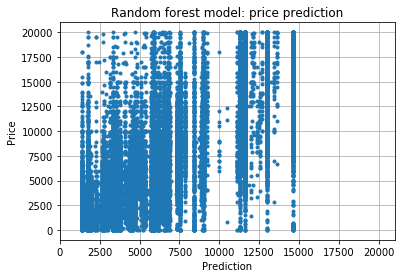

In [322]:
plt.figure()
plt.plot(prediction_test, target_test, '.')
plt.xlabel('Prediction')
plt.ylabel('Price')
plt.grid(True)
plt.title('Random forest model: price prediction')
plt.xlim([0, 21000])
plt.show()

This result better than linear model (RMSE_linear = 2763). <br>
We tune the parameters below.

In [323]:
%%time
# I have commented it
# CPU times: user 2h 50min 33s, sys: 17.4 s, total: 2h 50min 50s
#Wall time: 2h 53min 12s

# tune_random_forest = []
# for k_depth in range(5,10):
#     for k_estimators in range(50,210,30):
#         rf = RandomForestRegressor(n_estimators=k_estimators,
#                                     max_depth=k_depth,
#                                     random_state=12345)

#         rf.fit(features_train, target_train)
#         prediction_test = rf.predict(features_test)
#         prediction_train = rf.predict(features_train)

#         rmse_test_rf = mean_squared_error(target_test, prediction_test)
#         rmse_train_rf = mean_squared_error(target_train, prediction_train)
        
#         tune_random_forest.append([k_depth, k_estimators, rmse_train_rf ** 0.5, rmse_test_rf ** 0.5])

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


In [324]:
tune_random_forest_result = [[   5.        ,   50.        , 2429.93925796, 2444.89253424],
       [   5.        ,   80.        , 2429.38122913, 2444.30135681], [   5.        ,  110.        , 2430.00874872, 2444.85092461],
       [   5.        ,  140.        , 2429.77418752, 2444.59041352], [   5.        ,  170.        , 2429.65321925, 2444.42332414],
       [   5.        ,  200.        , 2429.45408411, 2444.25839308], [   6.        ,   50.        , 2276.29410992, 2287.52640184],
       [   6.        ,   80.        , 2275.97355124, 2287.35170153], [   6.        ,  110.        , 2275.94063535, 2287.3395518 ],
       [   6.        ,  140.        , 2276.06740696, 2287.47080873], [   6.        ,  170.        , 2275.91060376, 2287.19693799],
       [   6.        ,  200.        , 2275.4734229 , 2286.66028633], [   7.        ,   50.        , 2146.73762869, 2168.46217072],
       [   7.        ,   80.        , 2146.81898111, 2168.5388747 ], [   7.        ,  110.        , 2146.56393565, 2168.36669221],
       [   7.        ,  140.        , 2146.56136431, 2168.26078643], [   7.        ,  170.        , 2146.50918697, 2168.21167673],
       [   7.        ,  200.        , 2146.46765748, 2168.14730548], [   8.        ,   50.        , 2043.08422182, 2075.55735987],
       [   8.        ,   80.        , 2043.20787466, 2075.48574071], [   8.        ,  110.        , 2043.02733218, 2075.25933225],
       [   8.        ,  140.        , 2042.93528869, 2074.97812881], [   8.        ,  170.        , 2042.71831422, 2074.90260544],
       [   8.        ,  200.        , 2042.70076151, 2074.96863658], [   9.        ,   50.        , 1945.77693737, 1996.80764812],
       [   9.        ,   80.        , 1945.95215211, 1997.32933559], [   9.        ,  110.        , 1945.88531559, 1997.09010046],
       [   9.        ,  140.        , 1945.6250167 , 1996.77104965], [   9.        ,  170.        , 1945.6333063 , 1996.99578347],
       [   9.        ,  200.        , 1945.44605582, 1996.83040658]]

tune_random_forest = tune_random_forest_result

In [325]:
columns = ['max_depth','n_estimators','rmse_train_rf','rmse_test_rf']
df_tuning_rf = pd.DataFrame(tune_random_forest, columns=columns).sort_values(['rmse_train_rf'])

In [326]:
df_tuning_rf

,max_depth,n_estimators,rmse_train_rf,rmse_test_rf
29,9.0,200.0,1945.446056,1996.830407
27,9.0,140.0,1945.625017,1996.771050
28,9.0,170.0,1945.633306,1996.995783
24,9.0,50.0,1945.776937,1996.807648
26,9.0,110.0,1945.885316,1997.090100
25,9.0,80.0,1945.952152,1997.329336
23,8.0,200.0,2042.700762,2074.968637
22,8.0,170.0,2042.718314,2074.902605
21,8.0,140.0,2042.935289,2074.978129
20,8.0,110.0,2043.027332,2075.259332


**So...** The best parameters are n_estimators=200  , max_depth=9  . <br>
RMSE_test = 1996.8 (before tune RMSE = 2444.9) <br>
Results on test a little bit worse than Results on train. It seems that it is not overeducated.

### Gradient Boosting

#### lightgbm

In [327]:
from lightgbm import LGBMRegressor

In [328]:
%%time
lgbm = LGBMRegressor(random_state=12345)
lgbm.fit(features_train, target_train)

prediction_test = lgbm.predict(features_test)
prediction_train = lgbm.predict(features_train)

CPU times: user 54.9 s, sys: 992 ms, total: 55.9 s
Wall time: 56.5 s


In [329]:
rmse_test_lgbm = mean_squared_error(target_test, prediction_test)
rmse_train_lgbm = mean_squared_error(target_train, prediction_train)
print('RMSE of random forest model train: {:.1f}'.format(rmse_train_lgbm ** 0.5))
print('RMSE of random forest model test: {:.1f}'.format(rmse_test_lgbm ** 0.5))

RMSE of random forest model train: 1678.6
RMSE of random forest model test: 1711.6


**So...** It is so simple. Even with default parameters we obtain better results <br>
RMSE_lgbm = 1711.6 vs RMSE_random_forest_tuned = 1996.8 vs RMSE_random_forest = 2444.9 vs RMSE_linear_model = 2763.0

In [331]:
%%time
lgbm = LGBMRegressor(n_estimators=200,
                    random_state=12345) # n_estimators =100 (default)
lgbm.fit(features_train, target_train)

prediction_test = lgbm.predict(features_test)
prediction_train = lgbm.predict(features_train)

rmse_test_lgbm = mean_squared_error(target_test, prediction_test)
rmse_train_lgbm = mean_squared_error(target_train, prediction_train)
print('RMSE of random forest model train: {:.1f}'.format(rmse_train_lgbm ** 0.5))
print('RMSE of random forest model test: {:.1f}'.format(rmse_test_lgbm ** 0.5))

RMSE of random forest model train: 1605.7
RMSE of random forest model test: 1661.4
CPU times: user 1min 29s, sys: 1.08 s, total: 1min 30s
Wall time: 1min 31s


**So...** <br>
RMSE_lgbm_ver.1 = 1711.6 (default)
RMSE_lgbm_ver.2 = 1661.4

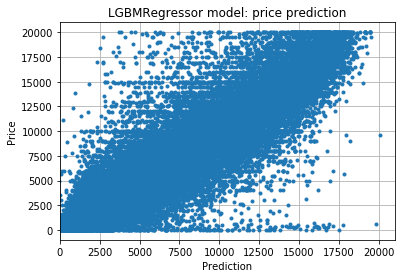

In [332]:
plt.figure()
plt.plot(prediction_test, target_test, '.')
plt.xlabel('Prediction')
plt.ylabel('Price')
plt.grid(True)
plt.title('LGBMRegressor model: price prediction')
plt.xlim([0, 21000])
plt.show()

#### catboost
In fact, we haven't use OHE for catboost, but why not? <br>
We don't know how using the internal implementation (analog OHE) in catboost could increase quality of model in comparison, when we do it by ourself. <br>

In [335]:
%%time
cat = CatBoostRegressor(random_state=12345) 
cat.fit(features_train, target_train)

prediction_test = cat.predict(features_test)
prediction_train = cat.predict(features_train)

rmse_test_cat = mean_squared_error(target_test, prediction_test)
rmse_train_cat = mean_squared_error(target_train, prediction_train)
print('RMSE of random forest model train: {:.1f}'.format(rmse_train_cat ** 0.5))
print('RMSE of random forest model test: {:.1f}'.format(rmse_test_cat ** 0.5))

0:	learn: 4443.0039751	total: 189ms	remaining: 3m 8s
1:	learn: 4358.8780373	total: 387ms	remaining: 3m 13s
2:	learn: 4278.3307517	total: 570ms	remaining: 3m 9s
3:	learn: 4201.1945667	total: 766ms	remaining: 3m 10s
4:	learn: 4124.3369081	total: 879ms	remaining: 2m 54s
5:	learn: 4048.3543474	total: 1.07s	remaining: 2m 57s
6:	learn: 3975.6368430	total: 1.26s	remaining: 2m 59s
7:	learn: 3907.4776238	total: 1.47s	remaining: 3m 1s
8:	learn: 3841.4913776	total: 1.68s	remaining: 3m 4s
9:	learn: 3777.1327082	total: 1.87s	remaining: 3m 5s
10:	learn: 3714.8163192	total: 2.06s	remaining: 3m 5s
11:	learn: 3655.8461079	total: 2.26s	remaining: 3m 5s
12:	learn: 3600.1985497	total: 2.44s	remaining: 3m 5s
13:	learn: 3545.2062055	total: 2.65s	remaining: 3m 7s
14:	learn: 3493.8997870	total: 2.85s	remaining: 3m 7s
15:	learn: 3444.9911853	total: 3.05s	remaining: 3m 7s
16:	learn: 3398.3232079	total: 3.17s	remaining: 3m 3s
17:	learn: 3354.3268540	total: 3.36s	remaining: 3m 3s
18:	learn: 3309.0815666	total: 3.

In [344]:
%%time
result_cat_tune = []
for k_estimators in range(100, 400, 100):
    for k_max_depth in range(7, 10):
        cat = CatBoostRegressor(loss_function='RMSE',
                                n_estimators=k_estimators,
                                max_depth=k_max_depth,
                                random_state=12345) 
        cat.fit(features_train, target_train)

        prediction_test = cat.predict(features_test)
        prediction_train = cat.predict(features_train)

        rmse_test_cat = mean_squared_error(target_test, prediction_test) ** 0.5
        rmse_train_cat = mean_squared_error(target_train, prediction_train) ** 0.5

        result_cat_tune.append([k_estimators, k_max_depth, rmse_train_cat, rmse_test_cat])

0:	learn: 4439.2215287	total: 117ms	remaining: 11.6s
1:	learn: 4350.6609127	total: 405ms	remaining: 19.9s
2:	learn: 4266.6390682	total: 607ms	remaining: 19.6s
3:	learn: 4183.7834175	total: 813ms	remaining: 19.5s
4:	learn: 4106.5417112	total: 1.01s	remaining: 19.2s
5:	learn: 4029.4140904	total: 1.21s	remaining: 19s
6:	learn: 3956.3340255	total: 1.41s	remaining: 18.7s
7:	learn: 3886.1864467	total: 1.61s	remaining: 18.5s
8:	learn: 3816.6312837	total: 1.81s	remaining: 18.3s
9:	learn: 3751.2434222	total: 2.01s	remaining: 18.1s
10:	learn: 3688.6509241	total: 2.3s	remaining: 18.6s
11:	learn: 3626.3741439	total: 2.49s	remaining: 18.3s
12:	learn: 3567.3408158	total: 2.69s	remaining: 18s
13:	learn: 3511.7279146	total: 2.81s	remaining: 17.3s
14:	learn: 3457.2932473	total: 3.01s	remaining: 17.1s
15:	learn: 3406.1915877	total: 3.2s	remaining: 16.8s
16:	learn: 3356.2692629	total: 3.4s	remaining: 16.6s
17:	learn: 3306.7599412	total: 3.68s	remaining: 16.7s
18:	learn: 3260.0940058	total: 3.89s	remainin

In [351]:
columns = ['n_estimators','max_depth','rmse_train_cat','rmse_test_cat']
df_tuning_cat = pd.DataFrame(result_cat_tune, columns=columns).sort_values(['rmse_train_cat'])

In [353]:
df_tuning_cat['rmse_train_cat'] = df_tuning_cat['rmse_train_cat'] ** 0.5
df_tuning_cat['rmse_test_cat'] = df_tuning_cat['rmse_test_cat'] ** 0.5

In [354]:
df_tuning_cat

,n_estimators,max_depth,rmse_train_cat,rmse_test_cat
8,300,9,1745.103016,1773.234756
7,300,8,1774.332491,1797.091059
5,200,9,1806.399362,1829.934709
6,300,7,1811.090035,1828.903255
4,200,8,1840.135722,1859.541656
3,200,7,1880.106364,1896.156947
2,100,9,1968.258020,1986.315584
1,100,8,2008.358212,2025.022235
0,100,7,2057.783156,2072.461138


In [ ]:
#print('RMSE of random forest model train: {:.1f}'.format(rmse_train_cat ** 0.5))
#print('RMSE of random forest model test: {:.1f}'.format(rmse_test_cat ** 0.5))

**So...** <br>
RMSE_cat_ver.1 = 1714.7 (default)
RMSE_cat_ver.2 = 1773.2 (little tuning)

## Model analysis
This part is a result and analysis of the previous part. <br>
Let's sum up results and look through them.

**So...** Sum up our results: <br>
RMSE_linear_model = 2763.0 (sanity check) very fast<br>
RMSE_random_forest = 2444.9 fast <br>
RMSE_random_forest_tuned = 1996.8 (ranges: n_estimators, max_depth) slow 3hours<br>
RMSE_lgbm_ver.1 = 1711.6 (default) fast<br>
RMSE_lgbm_ver.2 = 1661.4 (n_estimators=200) fast<br>
RMSE_cat_ver.1 = 1714.7 (default) fast<br>
RMSE_cat_tuned = 1773.2 (ranges: n_estimators, max_depth) middle 8min<br>
<br>
All of this models seems to be not overeducated. The best result gives lgbm library. I think we can tune parameters to improve quality of the model to obtain the same result for cat_boost. It is cool that we can this good result just from the box.<br>
<br>
To improve the model we can include dates, which I have dropped. <br>
We can try tune the model hyperparameters of gradient boosting. It seems that we haven't found the key parameters, that could dramatically increase the quality. <br>
We can try to use XGBoost (analogue of CatBoost), but it is unlikely that it could increase the quality. <br>
Maybe we should better process the data. It was very strange, that some cars have very low price (<100EUR). <br>


# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed